# Introduction:
The dataset I chose is the Marketing Campaigns dataset.

## Notes and Comments about this Dataset:
This dataset contains information about marketing campaigns, user interactions, and subscription details. It includes:
User demographics (age_group, language_preferred).
Campaign details (marketing_channel, date_served, converted).
Subscription outcomes (date_subscribed, is_retained).
Certain columns, such as language_displayed and language_preferred, provide insights into language consistency during campaigns.
Missing values are present in some columns (e.g., date_canceled) but do not require removal as they represent meaningful information (e.g., retained users).
Additional columns like channel_code and is_correct_lang were engineered to enhance the analysis.

## The Questions about this Dataset:
Does a mismatch between language_displayed and language_preferred impact conversion rates?

Is there a significant difference in conversions for users shown ads in their preferred vs. non-preferred language?
Which marketing channels have the highest conversion rates?

How do channels like House Ads, Instagram, and Facebook perform relative to each other?
How does the day of the week (DoW) affect subscription rates?

Are there patterns in user activity across different days of the week?
What are the key features associated with higher user retention?

Does the user's preferred language, age group, or subscribing channel predict retention?
What trends can be observed in daily marketing reach?

How do user interactions vary over time across different marketing channels?

In [1]:
import pandas as pd # Import pandas into the environment
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy.stats import ttest_ind

In [2]:
marketing = pd.read_csv('marketing.csv')
print(marketing.head()) # Print the first five rows of the DataFrame

      user_id date_served marketing_channel converted language_displayed  \
0  a100000029    01/01/18         House Ads      True            English   
1  a100000030    01/01/18         House Ads      True            English   
2  a100000031    01/01/18         House Ads      True            English   
3  a100000032    01/01/18         House Ads      True            English   
4  a100000033    01/01/18         House Ads      True            English   

  language_preferred    age_group date_subscribed date_canceled  \
0            English   0-18 years        01/01/18           NaN   
1            English  19-24 years        01/01/18           NaN   
2            English  24-30 years        01/01/18           NaN   
3            English  30-36 years        01/01/18           NaN   
4            English  36-45 years        01/01/18           NaN   

  subscribing_channel is_retained  
0           House Ads        True  
1           House Ads        True  
2           House Ads        Tru

In [3]:
marketing.describe()# Print the statistics of all columns

,user_id,date_served,marketing_channel,converted,language_displayed,language_preferred,age_group,date_subscribed,date_canceled,subscribing_channel,is_retained
count,10037,10021,10022,10022,10037,10037,10037,1856,577,1856,1856
unique,7309,31,5,2,4,4,7,31,115,5,2
top,a100000882,01/15/18,House Ads,False,English,English,19-24 years,01/16/18,04/02/18,Instagram,True
freq,12,789,4733,8946,9793,9275,1682,163,15,600,1279


In [4]:
marketing.info() # check info of the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10037 entries, 0 to 10036
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   user_id              10037 non-null  object
 1   date_served          10021 non-null  object
 2   marketing_channel    10022 non-null  object
 3   converted            10022 non-null  object
 4   language_displayed   10037 non-null  object
 5   language_preferred   10037 non-null  object
 6   age_group            10037 non-null  object
 7   date_subscribed      1856 non-null   object
 8   date_canceled        577 non-null    object
 9   subscribing_channel  1856 non-null   object
 10  is_retained          1856 non-null   object
dtypes: object(11)
memory usage: 862.7+ KB


### Changing Datatype and Feature Engineering

In [5]:
# Changing datatypes to bool
marketing["converted"] = marketing["converted"].apply(lambda x: bool(x) if pd.notna(x) else None)
marketing["is_retained"]= marketing["is_retained"].apply(lambda x: bool(x) if pd.notna(x) else None)

In [6]:
# Feature Engineering
# Adding a new column, channel_code, which maps the values in the subscribing_channel column to a numeric scale using the channel_dict dictionary.
channel_dict= {"House Ads":1,
               "Instagram":2,
               "Facebook":3,
               "Email":4,
               "Push":5
              }
# Map the channel to a channel code
marketing['channel_code']= marketing['subscribing_channel'].map(channel_dict)

In [7]:
# Adding a new column, is_correct_lang, which is 'Yes' if the user was shown the ad in their preferred language, 'No' otherwise
marketing['is_correct_lang'] = np.where(
    marketing['language_preferred'] == marketing['language_displayed'],
    "Yes",
    "No"
)

In [8]:
# Chainging datatype of date columns

marketing = marketing.astype({
    "date_served": "datetime64[ns]",
    "date_subscribed": "datetime64[ns]",
    "date_canceled": "datetime64[ns]"
})

# Add a DoW column
marketing['DoW'] = marketing['date_subscribed'].dt.dayofweek

### Checking and removing duplicates

In [9]:
# Checking duplicates based on different columns
duplicate = marketing.duplicated(['user_id', 'date_served', 'marketing_channel'])

# Checking if there are any duplicates
has_duplicates = duplicate.any()

# Printing results
print(f"has_duplicates: {has_duplicates}")

print(f"Duplicate sum: {duplicate.sum()}")


# Additional duplicate counts (optional)
print(duplicate.sum())



has_duplicates: True
Duplicate sum: 165
165


In [10]:
# Dropping duplicates inplace based on 'user_id', 'date_served', and 'marketing_channel'
marketing.drop_duplicates(subset=['user_id', 'date_served', 'marketing_channel'], keep='first', inplace=True)

# Verifying if duplicates have been removed
remaining_duplicates = marketing.duplicated(['user_id', 'date_served', 'marketing_channel']).sum()

# Printing results
print(f"Remaining duplicates after inplace removal: {remaining_duplicates}")


Remaining duplicates after inplace removal: 0


### Daily marketing reach by channel

In [11]:
# Group by date_served and count number of unique user_id's
daily_users = marketing.groupby(['date_served'])['user_id'].nunique()

# Print head of daily_users
print(daily_users.head())

date_served
2018-01-01    362
2018-01-02    374
2018-01-03    348
2018-01-04    323
2018-01-05    319
Name: user_id, dtype: int64


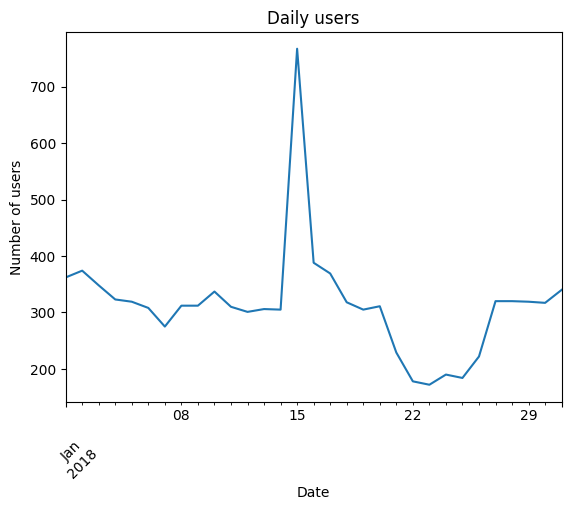

In [12]:
# Plot daily_users
daily_users.plot()

# Include a title and y-axis label
plt.title('Daily users')
plt.xlabel('Date')
plt.ylabel('Number of users')

# Rotate the x-axis labels by 45 degrees
plt.xticks(rotation=45)

# Display the plot
plt.show()

### Calculating conversion rate

In [13]:
# Calculate the number of people we marketed to
total_user = marketing['user_id'].nunique()

# Calculate the number of people who subscribed
subscribers = marketing[marketing['converted'] == True]['user_id'].nunique()

# Calculate the conversion rate
conversion_rate = subscribers / total_user

# Print the conversion rate as a percentage
print(conversion_rate)
print(round(conversion_rate * 100, 2), "%")

0.13886988644137366
13.89 %


### Calculating retention rate

In [14]:
# Calculate the number of people who remained subscribed
retained = marketing[marketing['is_retained']==True]['user_id'].nunique()
print(retained)
# Calculate the retention rate
retention_rate = retained/subscribers
print(retention_rate)
print(round(retention_rate*100, 2), "%")

670
0.6600985221674877
66.01 %


### Comparing language conversion rate (I)

In [15]:
# Isolate english speakers
english_speakers = marketing[marketing['language_displayed'] == 'English']

# Calculate the total number of English speaking users
total_english_speaker = english_speakers['user_id'].nunique()

# Calculate the number of English speakers who converted
english_subscribers =english_speakers[english_speakers['converted']==True]['user_id'].nunique()

# Calculate conversion rate
conversion_rate = english_subscribers/total_english_speaker
print('English speaker conversion rate:', round(conversion_rate*100,2), '%')

English speaker conversion rate: 12.92 %


### Comparing language conversion rate (II)

In [16]:
# Group by language_displayed and count unique users
total_user_per_language = marketing.groupby(['language_displayed'])['user_id'].nunique()

# Group by language_displayed and count unique conversions
subscribers_per_language = marketing[marketing['converted'] == True].groupby(['language_displayed'])['user_id'].nunique()

# Calculate the conversion rate for all languages
language_conversion_rate = subscribers_per_language/total_user_per_language
print(language_conversion_rate)

language_displayed
Arabic     0.500000
English    0.129167
German     0.726027
Spanish    0.200000
Name: user_id, dtype: float64


In [17]:
total_user_per_language

language_displayed
Arabic       24
English    7169
German       73
Spanish     120
Name: user_id, dtype: int64

In [18]:
subscribers_per_language

language_displayed
Arabic      12
English    926
German      53
Spanish     24
Name: user_id, dtype: int64

### Aggregating by date

In [19]:
# Group by date_served and count unique converted users
subscribers_per_day = marketing[marketing['converted'] == True].groupby('date_served')['user_id'].nunique()

# Calculate the conversion rate per day
daily_conversion_rate = subscribers_per_day / daily_users

# Display the daily conversion rate
print(daily_conversion_rate)


date_served
2018-01-01    0.099448
2018-01-02    0.098930
2018-01-03    0.103448
2018-01-04    0.108359
2018-01-05    0.125392
2018-01-06    0.113636
2018-01-07    0.141818
2018-01-08    0.115385
2018-01-09    0.125000
2018-01-10    0.118694
2018-01-11    0.080645
2018-01-12    0.076412
2018-01-13    0.084967
2018-01-14    0.085246
2018-01-15    0.113429
2018-01-16    0.255155
2018-01-17    0.219512
2018-01-18    0.091195
2018-01-19    0.059016
2018-01-20    0.067524
2018-01-21    0.087336
2018-01-22    0.123596
2018-01-23    0.122093
2018-01-24    0.115789
2018-01-25    0.125000
2018-01-26    0.090090
2018-01-27    0.065625
2018-01-28    0.062500
2018-01-29    0.059561
2018-01-30    0.066246
2018-01-31    0.052941
Name: user_id, dtype: float64


### Visualize conversion rate by language

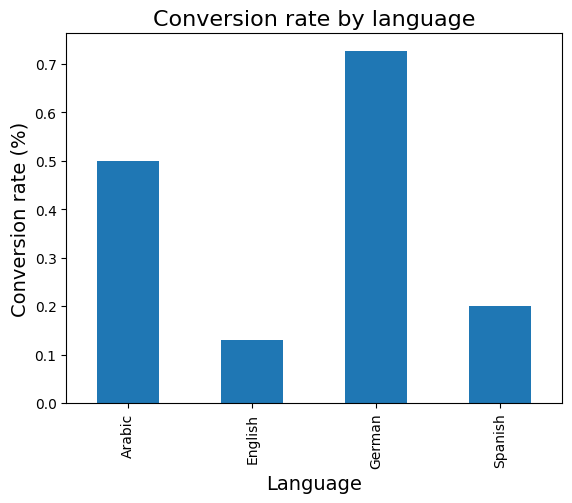

In [20]:
# Create a bar chart using language_conversion_rate DataFrame
language_conversion_rate.plot(kind= 'bar')

# Add a title and x and y-axis labels
plt.title('Conversion rate by language', size = 16)
plt.xlabel('Language', size = 14)
plt.ylabel('Conversion rate (%)', size = 14)

# Display the plot
plt.show()

### Setting up our data to visualize daily conversion

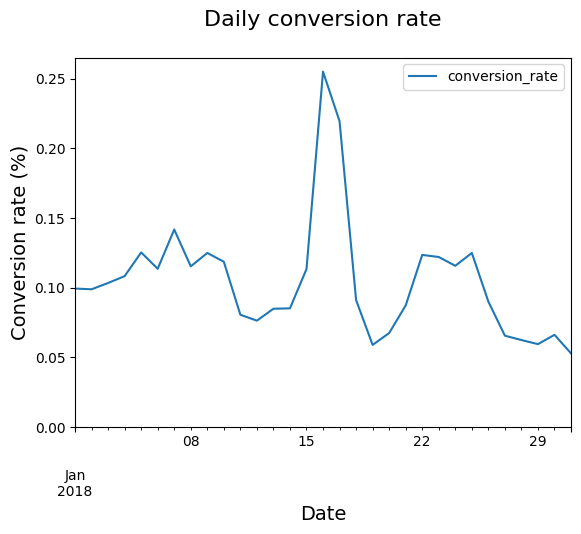

In [21]:
# Reset index to turn the results into a DataFrame
daily_conversion_rate = pd.DataFrame(daily_conversion_rate.reset_index(name='conversion_rate'))

# Rename columns
daily_conversion_rate.columns = ['date_served', 
                              'conversion_rate']

# Create a line chart using daily_conversion_rate
daily_conversion_rate.plot('date_served','conversion_rate')

plt.title('Daily conversion rate\n', size = 16)
plt.ylabel('Conversion rate (%)', size = 14)
plt.xlabel('Date', size = 14)

# Set the y-axis to begin at 0
plt.ylim(0)

# Display the plot
plt.show()

### Marketing channels across age groups

In [22]:
channel_age = marketing.groupby(['marketing_channel', 'age_group'])['user_id'].count()
print(channel_age)

marketing_channel  age_group  
Email              0-18 years      91
                   19-24 years    108
                   24-30 years    116
                   30-36 years     60
                   36-45 years     63
                   45-55 years     64
                   55+ years       53
Facebook           0-18 years     258
                   19-24 years    342
                   24-30 years    291
                   30-36 years    245
                   36-45 years    222
                   45-55 years    297
                   55+ years      176
House Ads          0-18 years     682
                   19-24 years    742
                   24-30 years    665
                   30-36 years    691
                   36-45 years    584
                   45-55 years    663
                   55+ years      619
Instagram          0-18 years     298
                   19-24 years    308
                   24-30 years    278
                   30-36 years    255
                   

In [23]:
# Unstack channel_age and transform it into a DataFrame
channel_age_df = pd.DataFrame(channel_age.unstack(level = 1))
channel_age_df

age_group,0-18 years,19-24 years,24-30 years,30-36 years,36-45 years,45-55 years,55+ years
marketing_channel,,,,,,,
Email,91,108,116,60,63,64,53
Facebook,258,342,291,245,222,297,176
House Ads,682,742,665,691,584,663,619
Instagram,298,308,278,255,277,223,201
Push,184,144,181,85,192,82,117


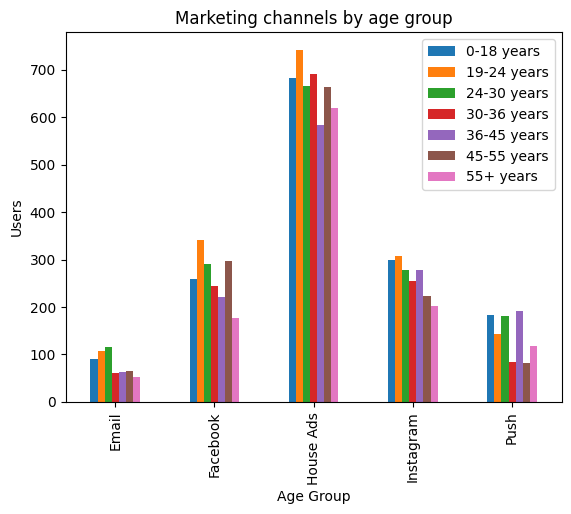

In [24]:
# Plot channel_age
channel_age_df.plot(kind = 'bar')
plt.title('Marketing channels by age group')
plt.xlabel('Age Group')
plt.ylabel('Users')
# Add a legend to the plot
plt.legend(labels=channel_age_df.columns.values, loc='upper right')
plt.show()

### Grouping and counting by multiple columns

In [25]:
# Count the subs by subscribing channel and day
retention_total = marketing.groupby(['date_subscribed','subscribing_channel'])['user_id'].nunique()

# Print results
print(retention_total.head())

date_subscribed  subscribing_channel
2018-01-01       Email                   1
                 Facebook                8
                 House Ads              16
                 Instagram               7
                 Push                    3
Name: user_id, dtype: int64


In [26]:
# Sum the retained subs by subscribing channel and date subscribed
retention_subs = marketing[marketing['is_retained']==True].groupby(['date_subscribed', 'subscribing_channel'])['user_id'].nunique()

# Print results
print(retention_subs.head())

date_subscribed  subscribing_channel
2018-01-01       Email                   1
                 Facebook                7
                 House Ads              11
                 Instagram               5
                 Push                    3
Name: user_id, dtype: int64


### Analyzing retention rates for the campaign

In [27]:
# Divide retained subscribers by total subscribers
retention_rate = retention_subs/retention_total 
retention_rate

date_subscribed  subscribing_channel
2018-01-01       Email                  1.000000
                 Facebook               0.875000
                 House Ads              0.687500
                 Instagram              0.714286
                 Push                   1.000000
                                          ...   
2018-01-31       Email                  1.000000
                 Facebook               0.833333
                 House Ads              0.500000
                 Instagram              0.666667
                 Push                   0.500000
Name: user_id, Length: 154, dtype: float64

In [28]:
# Creating the dataframe
retention_rate_df = pd.DataFrame(retention_rate.unstack(level=1))
retention_rate_df

subscribing_channel,Email,Facebook,House Ads,Instagram,Push
date_subscribed,,,,,
2018-01-01,1.000000,0.875000,0.687500,0.714286,1.000000
2018-01-02,0.750000,1.000000,0.588235,0.625000,1.000000
2018-01-03,NaN,0.800000,0.647059,0.900000,0.666667
2018-01-04,0.500000,0.666667,0.466667,0.428571,NaN
2018-01-05,1.000000,0.500000,0.500000,0.636364,1.000000
2018-01-06,0.800000,0.571429,0.941176,0.400000,0.500000
2018-01-07,NaN,0.750000,0.526316,0.400000,0.666667
2018-01-08,NaN,0.888889,0.500000,0.625000,1.000000
2018-01-09,0.500000,0.166667,0.850000,0.666667,0.500000


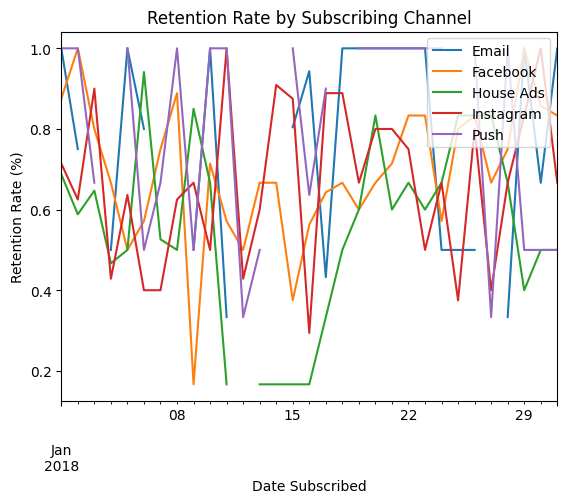

In [29]:
# Plot retention rate
retention_rate_df.plot()

# Add a title, x-label, y-label, legend and display the plot
plt.title('Retention Rate by Subscribing Channel')
plt.xlabel('Date Subscribed')
plt.ylabel('Retention Rate (%)')
plt.legend(loc='upper right', labels=retention_rate_df.columns.values)
plt.show()

### Building a conversion function

In [30]:
def conversion_rate(dataframe, column_names):
    # Total number of converted users
    column_conv = dataframe[dataframe['converted']==True].groupby(column_names)['user_id'].nunique()

    # Total number users
    column_total = dataframe.groupby(column_names)['user_id'].nunique()
    
    # Conversion rate 
    conversion_rate = column_conv/column_total
    
    # Fill missing values with 0
    conversion_rate = conversion_rate.fillna(0)
    return conversion_rate

### Testing and visualizing conversion function

date_served  age_group  
2018-01-01   0-18 years     0.155172
             19-24 years    0.196721
             24-30 years    0.105263
             30-36 years    0.040816
             36-45 years    0.042553
                              ...   
2018-01-31   24-30 years    0.057692
             30-36 years    0.000000
             36-45 years    0.035088
             45-55 years    0.023256
             55+ years      0.026316
Name: user_id, Length: 217, dtype: float64
age_group    0-18 years  19-24 years  24-30 years  30-36 years  36-45 years  \
date_served                                                                   
2018-01-01     0.155172     0.196721     0.105263     0.040816     0.042553   
2018-01-02     0.180328     0.164384     0.114754     0.040816     0.043478   
2018-01-03     0.102041     0.208955     0.153846     0.043478     0.061224   
2018-01-04     0.117647     0.200000     0.183673     0.045455     0.043478   
2018-01-05     0.142857     0.250000     0.136364  

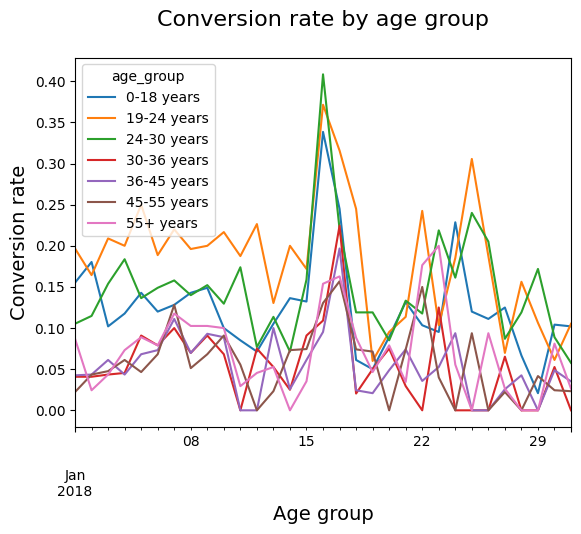

In [31]:
# Calculate conversion rate by age_group
age_group_conv = conversion_rate(marketing, ['date_served', 'age_group'])
print(age_group_conv)

# Unstack and create a DataFrame
age_group_df = pd.DataFrame(age_group_conv.unstack(level=1))
print(age_group_df)
# Visualize conversion by age_group
age_group_df.plot()
plt.title('Conversion rate by age group\n', size = 16)
plt.ylabel('Conversion rate', size = 14)
plt.xlabel('Age group', size = 14)
plt.show()

### Plotting function

In [32]:
def plotting_conv(dataframe):
    for column in dataframe:
        # Plot column by dataframe's index
        plt.plot(dataframe.index, dataframe[column])
        plt.title('Daily ' + str(column) + ' conversion rate\n', 
                  size = 16)
        plt.ylabel('Conversion rate', size = 14)
        plt.xlabel('Date', size = 14)
        plt.xticks(rotation=45)
        # Show plot
        plt.show() 
        plt.clf()

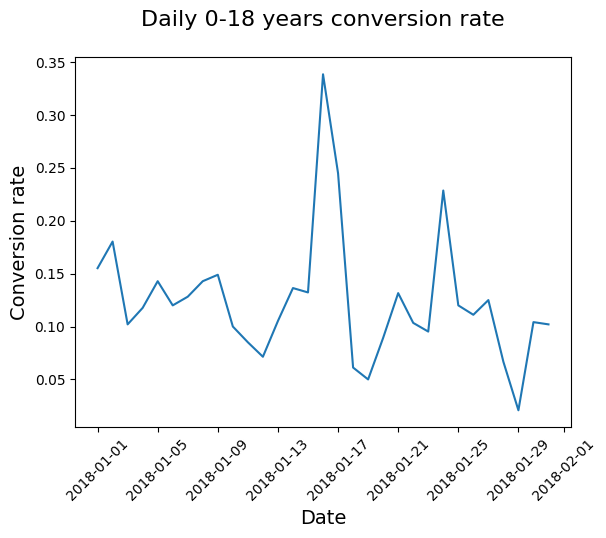

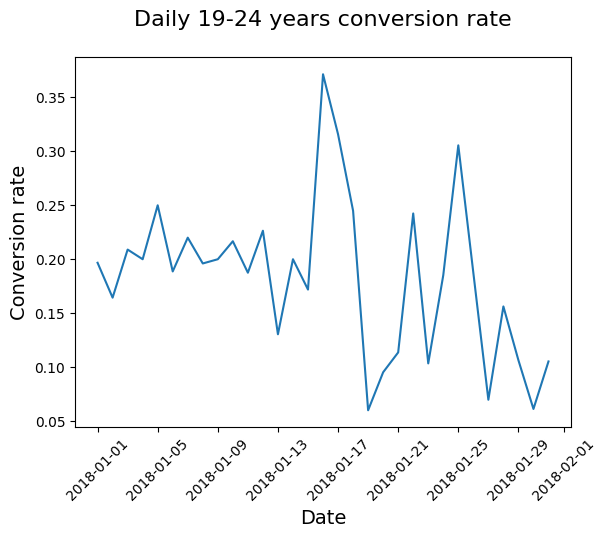

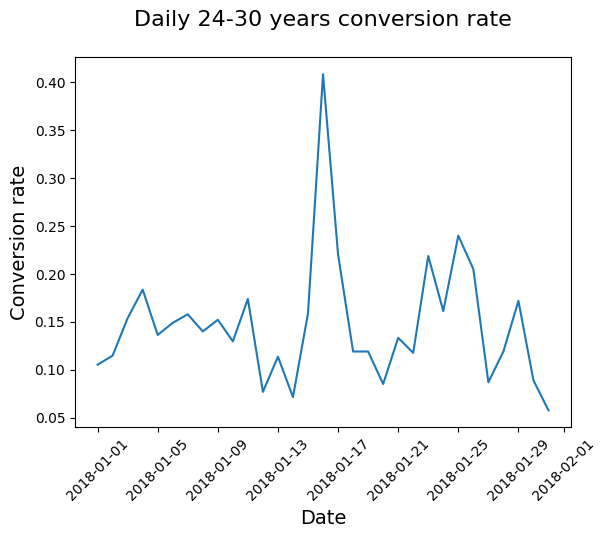

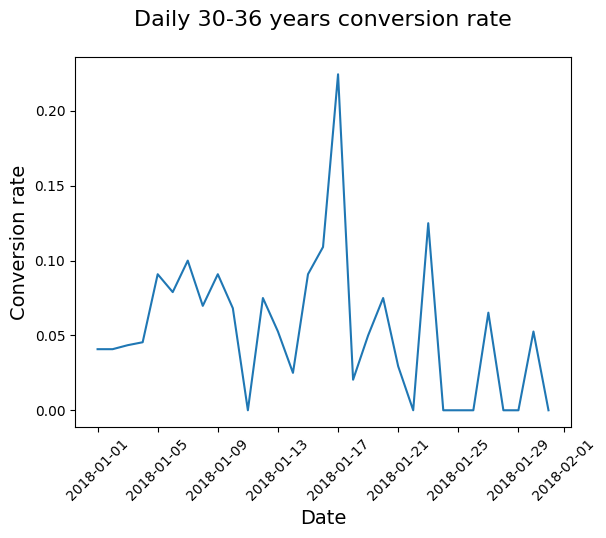

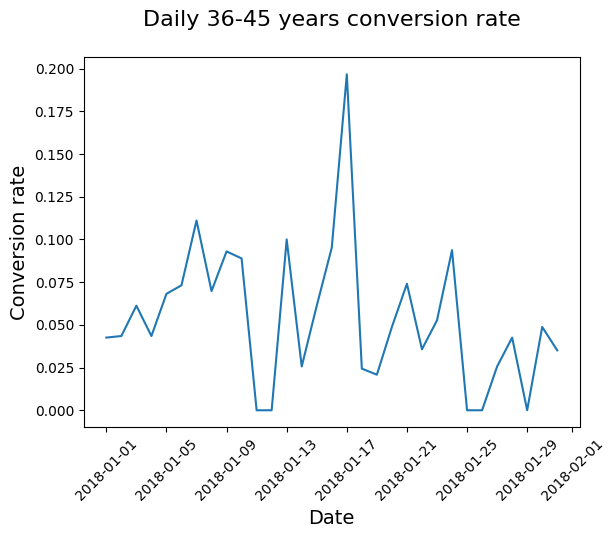

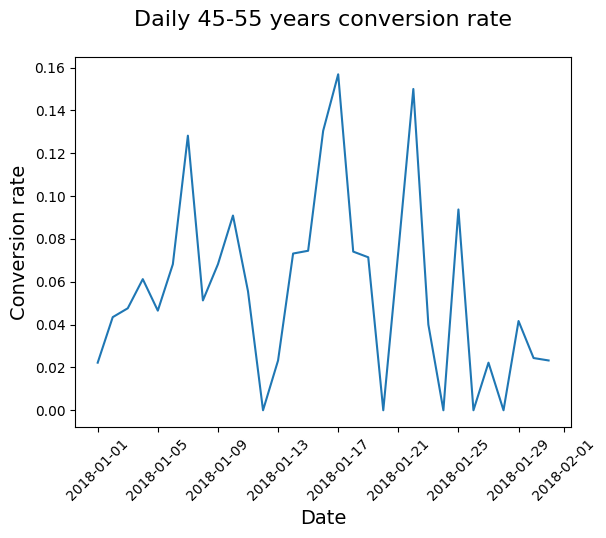

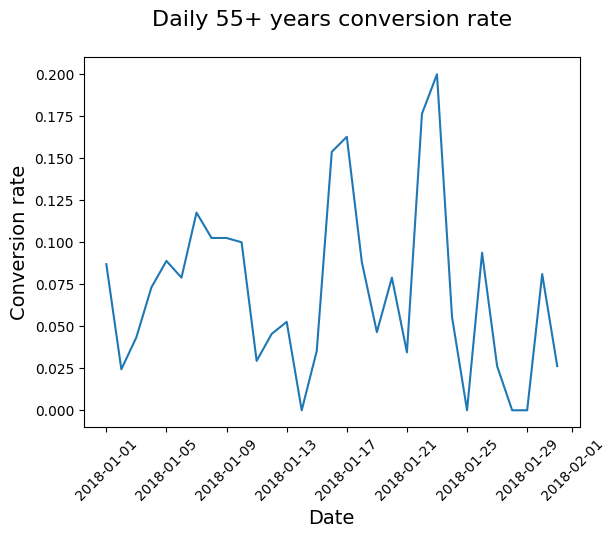

<Figure size 640x480 with 0 Axes>

In [33]:
# Calculate conversion rate by date served and age group
age_group_conv = conversion_rate(marketing,['date_served','age_group'])

# Unstack age_group_conv and create a DataFrame
age_group_df = pd.DataFrame(age_group_conv.unstack(level=1))

# Plot the results
plotting_conv(age_group_df)

## Identifying inconsistencies related to conversion rate

In [34]:
# Calculate conversion rate by date served and channel
daily_conv_channel = conversion_rate(marketing, ['date_served','marketing_channel'])
daily_conv_channel= pd.DataFrame(daily_conv_channel.unstack(level=-1))
daily_conv_channel

marketing_channel,Email,Facebook,House Ads,Instagram,Push
date_served,,,,,
2018-01-01,1.000000,0.117647,0.084656,0.106667,0.083333
2018-01-02,1.000000,0.098361,0.077982,0.129032,0.055556
2018-01-03,0.000000,0.080645,0.088542,0.171875,0.083333
2018-01-04,0.500000,0.138462,0.089820,0.126984,0.058824
2018-01-05,1.000000,0.112903,0.126582,0.159420,0.027778
2018-01-06,0.600000,0.111111,0.111842,0.095238,0.068966
2018-01-07,1.000000,0.096154,0.145038,0.175439,0.088235
2018-01-08,1.000000,0.136364,0.103896,0.125000,0.064516
2018-01-09,0.500000,0.120690,0.127389,0.152542,0.054054


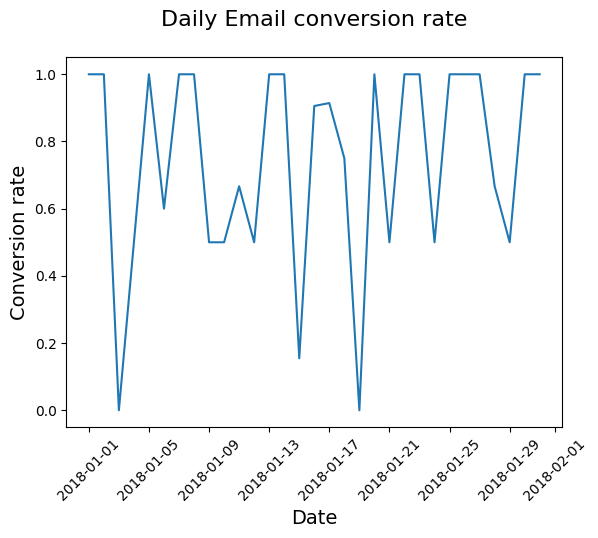

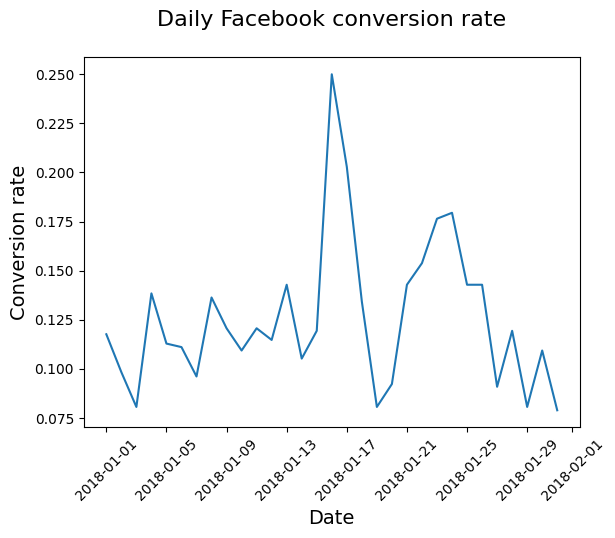

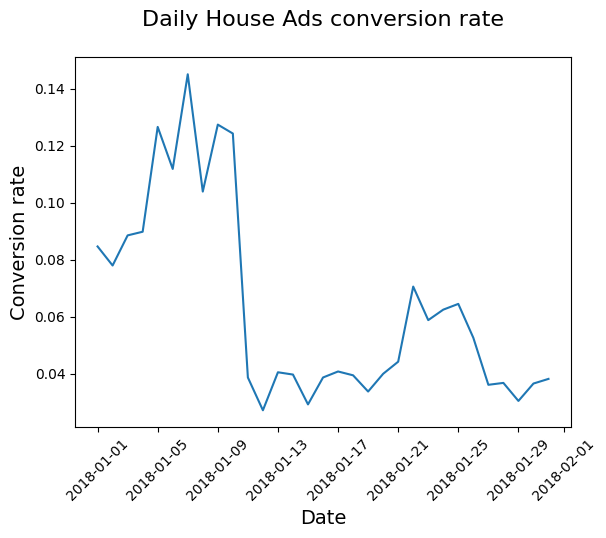

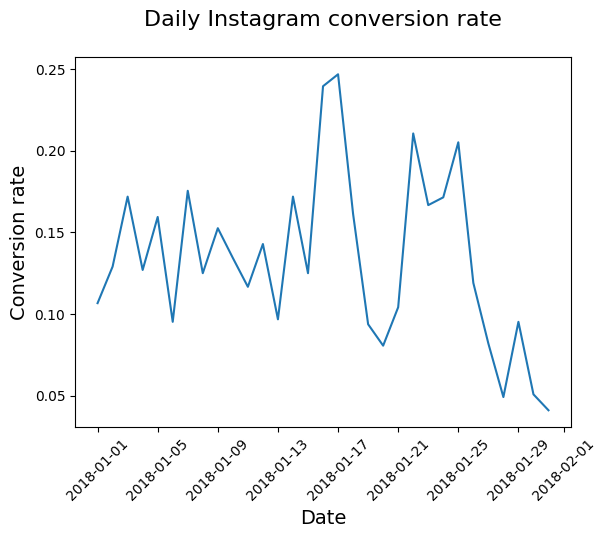

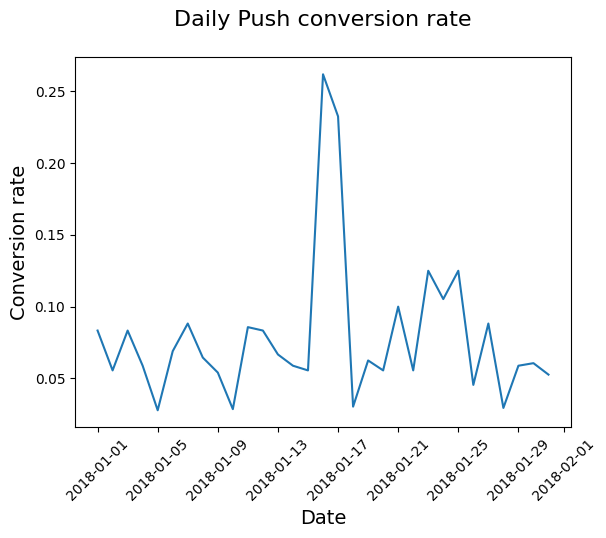

<Figure size 640x480 with 0 Axes>

In [35]:
# Plotting the df
plotting_conv(daily_conv_channel)

# A sudden decrease in conversion rate on January 11 for House Ads conversion rate.

### Analyzing House ads conversion rate

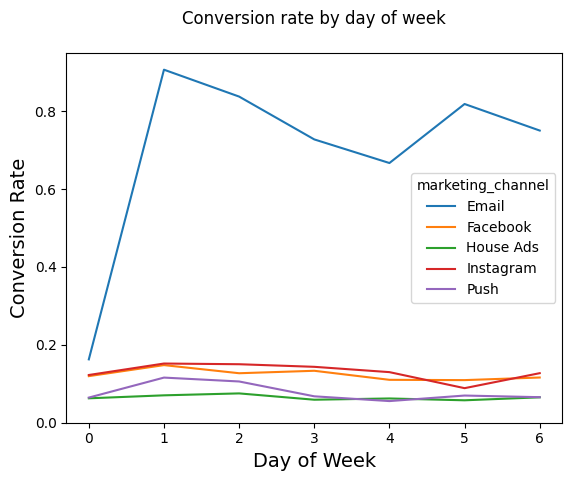

In [36]:
#checking whether users are more likely to convert
#on weekends compared with weekdays and determine if that could be the cause for the changing house ads conversion rate.

# Add day of week column to marketing
marketing['DoW_served'] = marketing['date_served'].dt.dayofweek

# Calculate conversion rate by day of week
DoW_conversion = conversion_rate(marketing, ['DoW_served', 'marketing_channel'])


# Unstack channels
DoW_df = pd.DataFrame(DoW_conversion.unstack(level=1))

# Plot conversion rate by day of week
DoW_df.plot(kind='line')
plt.title('Conversion rate by day of week\n')
plt.xlabel('Day of Week', fontsize=14)
plt.ylabel('Conversion Rate', fontsize=14)

# Set the y-axis to begin at 0
plt.ylim(0)

plt.show()



### Analyze conversion by language over time to determine if cultural differences impacted the effectiveness of the new marketing campaign.

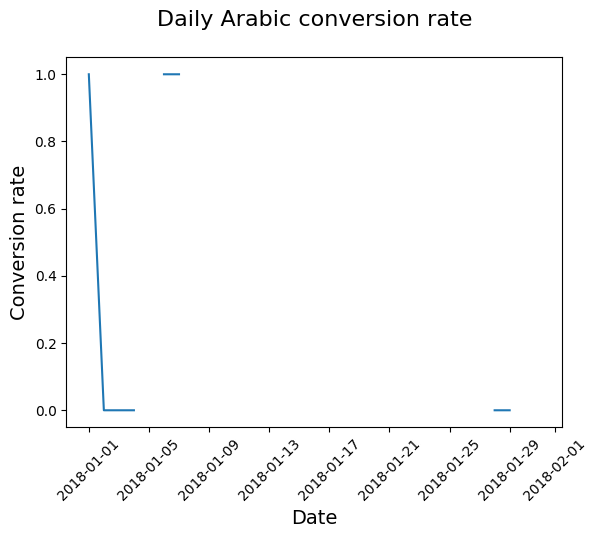

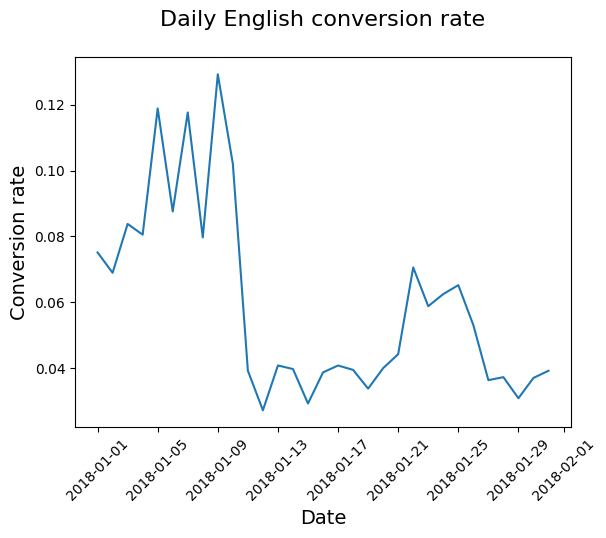

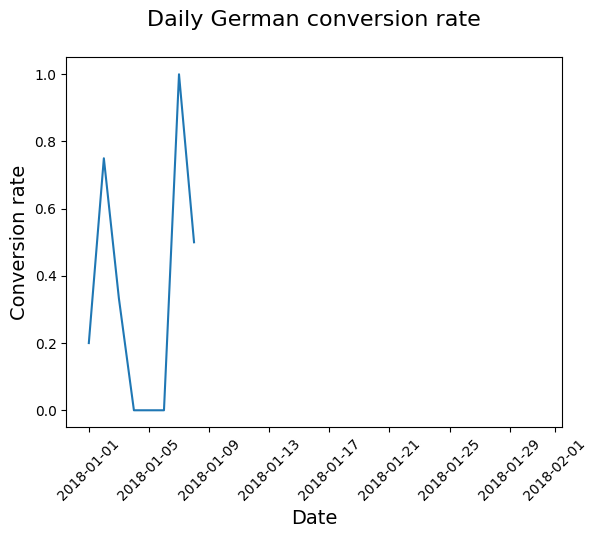

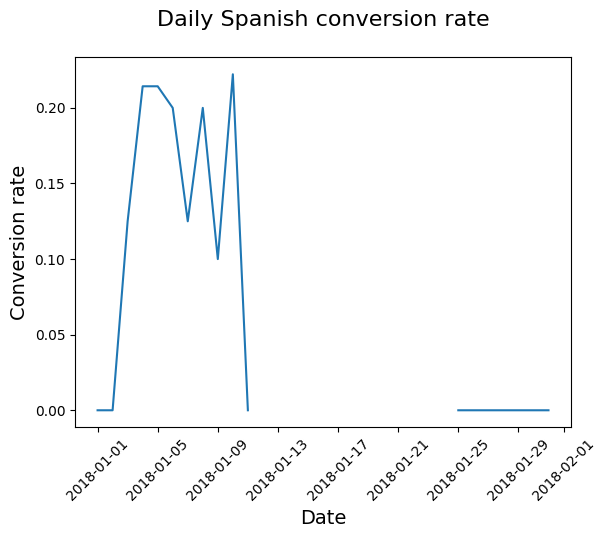

<Figure size 640x480 with 0 Axes>

In [37]:
# Isolate the rows where marketing channel is House Ads
house_ads = marketing[marketing['marketing_channel']=='House Ads']

# Calculate conversion by date served, and language displayed
conv_lang_channel = conversion_rate(house_ads,['date_served','language_displayed'])

# Unstack conv_lang_channel
conv_lang_df = pd.DataFrame(conv_lang_channel.unstack(level=1))

# Use your plotting function to display results
plotting_conv(conv_lang_df)

In [38]:
# Create a DataFrame to analyze house ads conversion trends and identify language-specific issues.

# Add the new column is_correct_lang
house_ads['is_correct_lang'] = np.where(
    house_ads['language_displayed'] == house_ads['language_preferred'], 
    'Yes', 
    'No')

# Groupby date_served and correct_language
language_check = house_ads.groupby(['date_served', 'is_correct_lang'])['is_correct_lang'].count()

# Unstack language_check and fill missing values with 0's
language_check_df = pd.DataFrame(language_check.unstack(level=1)).fillna(0)

# Print results
print(language_check_df)

is_correct_lang    No    Yes
date_served                 
2018-01-01        2.0  187.0
2018-01-02        3.0  215.0
2018-01-03        0.0  192.0
2018-01-04        0.0  167.0
2018-01-05        0.0  158.0
2018-01-06        1.0  151.0
2018-01-07        2.0  129.0
2018-01-08        0.0  154.0
2018-01-09        0.0  157.0
2018-01-10        0.0  169.0
2018-01-11       20.0  135.0
2018-01-12       18.0  129.0
2018-01-13       26.0  122.0
2018-01-14       20.0  131.0
2018-01-15       16.0  189.0
2018-01-16       28.0  127.0
2018-01-17       21.0  126.0
2018-01-18       31.0  121.0
2018-01-19       22.0  126.0
2018-01-20       26.0  124.0
2018-01-21       14.0   99.0
2018-01-22       13.0   72.0
2018-01-23       16.0   69.0
2018-01-24       13.0   83.0
2018-01-25       19.0   74.0
2018-01-26       24.0   90.0
2018-01-27       17.0  149.0
2018-01-28       27.0  136.0
2018-01-29       24.0  140.0
2018-01-30       23.0  141.0
2018-01-31       23.0  134.0


C:\Users\hasan\AppData\Local\Temp\ipykernel_23056\2615535819.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  house_ads['is_correct_lang'] = np.where(


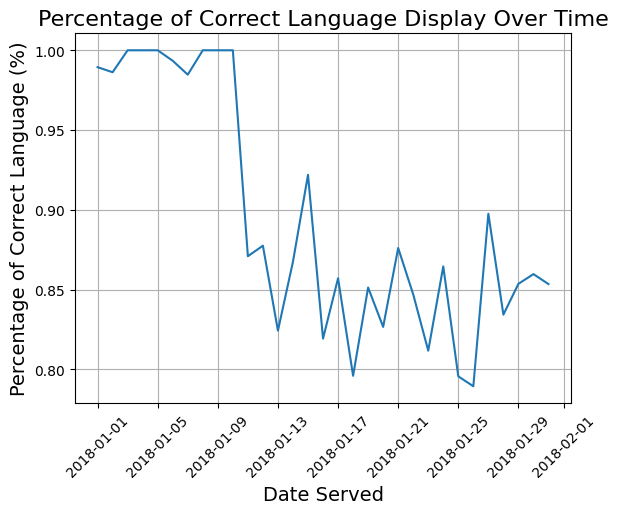

In [39]:
# Confirm house ads error by calculating the percentage of users served ads in the wrong language and plotting the results.

# Divide the count where language is correct by the row sum
language_check_df['pct'] = language_check_df['Yes']/language_check_df.sum(axis=1)

# Plot and show your results
plt.plot(language_check_df.index, language_check_df['pct'])
plt.title('Percentage of Correct Language Display Over Time', fontsize=16)
plt.xlabel('Date Served',fontsize=14)
plt.ylabel('Percentage of Correct Language (%)',fontsize=14)
plt.xticks(rotation=45)
plt.grid()
plt.show()

## Resolving inconsistencies

In [40]:
# Set up conversion indexes to compare non-English against English conversion rates before the language bug to estimate subscriber loss.

# Calculate pre-error conversion rate
house_ads_bug = house_ads[house_ads['date_served'] < '2018-01-11']
lang_conv = conversion_rate(house_ads_bug,'language_displayed')

# Index other language conversion rate against English
spanish_index = lang_conv['Spanish']/lang_conv['English']
arabic_index = lang_conv['Arabic']/lang_conv['English']
german_index = lang_conv['German']/lang_conv['English']

print("Spanish index:", spanish_index)
print("Arabic index:", arabic_index)
print("German index:", german_index)

Spanish index: 1.681924882629108
Arabic index: 5.045774647887324
German index: 4.657638136511376


In [41]:
# Creating a DataFrame to analyze user language preferences and calculate expected subscribers without the language bug.

# Group house_ads by date and language
converted = house_ads.groupby(['date_served','language_preferred'])\
                        .agg({'user_id':'nunique',
                              'converted':'sum'})

# Unstack converted
converted_df = pd.DataFrame(converted.unstack(level=1))

In [42]:
# Checking the dataframe
converted_df

user_id                        converted                 \
language_preferred  Arabic English German Spanish    Arabic English German   
date_served                                                                  
2018-01-01             2.0   171.0    5.0    11.0         2      13      1   
2018-01-02             3.0   200.0    5.0    10.0         0      14      3   
2018-01-03             2.0   179.0    3.0     8.0         0      15      1   
2018-01-04             2.0   149.0    2.0    14.0         0      12      0   
2018-01-05             NaN   143.0    1.0    14.0       NaN      17  False   
2018-01-06             3.0   136.0    2.0    11.0         3      12      0   
2018-01-07             2.0   117.0    2.0    10.0         2      14      2   
2018-01-08             NaN   138.0    6.0    10.0       NaN      11      3   
2018-01-09             NaN   147.0    NaN    10.0       NaN      19    NaN   
2018-01-10             NaN   147.0    4.0    18.0       NaN      15      2   
2018-01-11             7.0   133.0    2.0    13.0         0       6      0   
2018-01-12             3.0   129.0    4.0    11.0         0       3      0   
2018-01-13             6.0   121.0    5.0    16.0         0       5      1   
2018-01-14             5.0   131.0    3.0    12.0         0       6      0   
2018-01-15             2.0   189.0    4.0    10.0         0       6      0   
2018-01-16             7.0   127.0    4.0    17.0         0       6      0   
2018-01-17             2.0   126.0    3.0    16.0         0       2      0   
2018-01-18             7.0   121.0    6.0    18.0         0       5      1   
2018-01-19             5.0   126.0    5.0    12.0         1       4      0   
2018-01-20             6.0   124.0    6.0    14.0         1       4      1   
2018-01-21             1.0    99.0    4.0     9.0     False       5      0   
2018-01-22             2.0    72.0    3.0     8.0         1       4      1   
2018-01-23             3.0    69.0    4.0     9.0         0       5      0   
2018-01-24             2.0    83.0    3.0     8.0         0       6      0   
2018-01-25             3.0    75.0    4.0    11.0         0       4      2   
2018-01-26             6.0    89.0    3.0    16.0         0       4      0   
2018-01-27             3.0   148.0    3.0    12.0         1       4      0   
2018-01-28             5.0   134.0    3.0    21.0         0       4      0   
2018-01-29             7.0   138.0    4.0    15.0         2       3      0   
2018-01-30             4.0   139.0    3.0    18.0         0       4      0   
2018-01-31             7.0   130.0    4.0    16.0         1       4      0   

                            
language_preferred Spanish  
date_served                 
2018-01-01               0  
2018-01-02               0  
2018-01-03               1  
2018-01-04               3  
2018-01-05               3  
2018-01-06               2  
2018-01-07               1  
2018-01-08               2  
2018-01-09               1  
2018-01-10               4  
2018-01-11               0  
2018-01-12               1  
2018-01-13               0  
2018-01-14               0  
2018-01-15               0  
2018-01-16               0  
2018-01-17               4  
2018-01-18               0  
2018-01-19               0  
2018-01-20               0  
2018-01-21               0  
2018-01-22               0  
2018-01-23               0  
2018-01-24               0  
2018-01-25               0  
2018-01-26               2  
2018-01-27               1  
2018-01-28               2  
2018-01-29               0  
2018-01-30               2  
2018-01-31               1

In [43]:
# Building a DataFrame to estimate daily conversion rates if users were served the correct language, using indexed conversion rates.

# Create English conversion rate column for the affected period
converted['english_conv_rate'] = (
    converted.loc[('2018-01-11', 'English'), 'converted'] /
    converted.loc[('2018-01-11', 'English'), 'user_id']
)

# Create expected conversion rates for each language
converted['expected_spanish_rate'] = converted['english_conv_rate'] * converted.loc[('2018-01-11', 'Spanish'), 'converted']
converted['expected_arabic_rate'] = converted['english_conv_rate'] * converted.loc[('2018-01-11', 'Arabic'), 'converted']
converted['expected_german_rate'] = converted['english_conv_rate'] * converted.loc[('2018-01-11', 'German'), 'converted']

# Multiply the number of users by the expected conversion rate
converted['expected_spanish_conv'] = converted['expected_spanish_rate'] * converted.loc[('2018-01-11', 'Spanish'), 'user_id'] / 100
converted['expected_arabic_conv'] = converted['expected_arabic_rate'] * converted.loc[('2018-01-11', 'Arabic'), 'user_id'] / 100
converted['expected_german_conv'] = converted['expected_german_rate'] * converted.loc[('2018-01-11', 'German'), 'user_id'] / 100


In [44]:
# Calculate the number of subscribers lost due to the language bug to help evaluate the trade-off of implementing additional checks.

# Use .loc to slice only the relevant dates
converted = converted.loc['2018-01-11':'2018-01-31']

# Sum expected subscribers for each language
expected_subs = (
    converted['expected_spanish_conv'].sum() +
    converted['expected_arabic_conv'].sum() +
    converted['expected_german_conv'].sum()
)

# Calculate how many subscribers we actually got
actual_subs = (
    converted.loc[(slice(None), 'Spanish'), 'converted'].sum() +
    converted.loc[(slice(None), 'Arabic'), 'converted'].sum() +
    converted.loc[(slice(None), 'German'), 'converted'].sum()
)

# Subtract how many subscribers we got despite the bug
lost_subs = expected_subs - actual_subs
print(lost_subs)


-26.0
